# Import and Device

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# If fdi_models.py is in the same directory as the notebook:
from fdi_models import BiLSTMFDIDetector, count_parameters

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Load Prepared Dataset

In [147]:
DATA_PATH = "prepared_data/smartgrid_fdi_seq5_diff0.95 same 7 features.npz"  

data = np.load(DATA_PATH, allow_pickle=True)
print("Keys:", data.files)

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

print("Train label counts:", np.bincount(y_train.astype(int)))
print("Val label counts:  ", np.bincount(y_val.astype(int)))
print("Test label counts: ", np.bincount(y_test.astype(int)))

# Function to take half the dataset
def take_half(X, y):
    n = len(X)
    idx = np.random.permutation(n)[: n // 2]
    return X[idx], y[idx]

X_train, y_train = take_half(X_train, y_train)
X_val,   y_val   = take_half(X_val,   y_val)
X_test,  y_test  = take_half(X_test,  y_test)

print("Train half:", X_train.shape, y_train.shape)
print("Val half:  ", X_val.shape,   y_val.shape)
print("Test half: ", X_test.shape,  y_test.shape)




Keys: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']
X_train: (8000, 5, 15) y_train: (8000,)
X_val:   (1000, 5, 15) y_val:   (1000,)
X_test:  (1000, 5, 15) y_test:  (1000,)
Train label counts: [4000 4000]
Val label counts:   [500 500]
Test label counts:  [500 500]
Train half: (4000, 5, 15) (4000,)
Val half:   (500, 5, 15) (500,)
Test half:  (500, 5, 15) (500,)


# Organizing Dataset to Dataloaders

In [148]:
class SequenceFDIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 128

train_ds = SequenceFDIDataset(X_train, y_train)
val_ds   = SequenceFDIDataset(X_val,   y_val)
test_ds  = SequenceFDIDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)




(4000, 500, 500)

# Instantiate BiLSTM from .py

In [149]:
input_dim = X_train.shape[2]

model = BiLSTMFDIDetector(
    input_dim=input_dim,
    hidden_dim=32,
    num_layers=1,
    bidirectional=True,
    dropout=0.15,
).to(DEVICE)

print(model)
print("Trainable parameters:", count_parameters(model))

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

BiLSTMFDIDetector(
  (lstm): LSTM(15, 32, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Trainable parameters: 16769


# Training Loop

In [150]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def batch_accuracy_from_logits(logits: torch.Tensor, labels: torch.Tensor) -> float:
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    return (preds == labels).float().mean().item()

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_n = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            n = y_batch.size(0)
            total_loss += loss.item() * n
            total_acc  += batch_accuracy_from_logits(logits, y_batch) * n
            total_n += n

    return total_loss / total_n, total_acc / total_n


NUM_EPOCHS = 500
LOSS_THRESHOLD = 0.1
best_val_loss = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_n = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        n = y_batch.size(0)
        running_loss += loss.item() * n
        running_acc  += batch_accuracy_from_logits(logits, y_batch) * n
        total_n += n

    train_loss = running_loss / total_n
    train_acc  = running_acc / total_n
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_bilstm_fdi_detector.pt")
        print("  -> Saved new best model.")
        # Early stop if we reached the desired validation loss
        
    if val_loss < LOSS_THRESHOLD:
        print(f"  -> Validation loss {val_loss:.4f} < {LOSS_THRESHOLD}, early stopping at epoch {epoch}.")
        break




Epoch 01 | Train Loss: 0.6933, Acc: 0.5125 | Val Loss: 0.6941, Acc: 0.5000
  -> Saved new best model.
Epoch 02 | Train Loss: 0.6927, Acc: 0.5228 | Val Loss: 0.6942, Acc: 0.5000
Epoch 03 | Train Loss: 0.6922, Acc: 0.5165 | Val Loss: 0.6938, Acc: 0.5060
  -> Saved new best model.
Epoch 04 | Train Loss: 0.6917, Acc: 0.5347 | Val Loss: 0.6944, Acc: 0.5080
Epoch 05 | Train Loss: 0.6905, Acc: 0.5410 | Val Loss: 0.6941, Acc: 0.5000
Epoch 06 | Train Loss: 0.6885, Acc: 0.5403 | Val Loss: 0.6943, Acc: 0.5200
Epoch 07 | Train Loss: 0.6848, Acc: 0.5547 | Val Loss: 0.6971, Acc: 0.4840
Epoch 08 | Train Loss: 0.6874, Acc: 0.5453 | Val Loss: 0.6866, Acc: 0.5500
  -> Saved new best model.
Epoch 09 | Train Loss: 0.6790, Acc: 0.5815 | Val Loss: 0.6794, Acc: 0.5620
  -> Saved new best model.
Epoch 10 | Train Loss: 0.6704, Acc: 0.5933 | Val Loss: 0.6619, Acc: 0.6000
  -> Saved new best model.
Epoch 11 | Train Loss: 0.6601, Acc: 0.6120 | Val Loss: 0.6494, Acc: 0.6400
  -> Saved new best model.
Epoch 12 | Tr

In [151]:
# Load best model for testing
model.load_state_dict(torch.load("best_bilstm_fdi_detector.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

all_logits = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        logits = model(X_batch)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

all_logits = np.concatenate(all_logits)
all_labels = np.concatenate(all_labels)

probs = 1 / (1 + np.exp(-all_logits))   # sigmoid
preds = (probs >= 0.5).astype(np.float32)

acc  = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec  = recall_score(all_labels, preds)
f1   = f1_score(all_labels, preds)
cm   = confusion_matrix(all_labels, preds)

print("Test Accuracy :", acc)
print("Test Precision:", prec)
print("Test Recall   :", rec)
print("Test F1       :", f1)
print("Confusion matrix:\n", cm)

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Test Accuracy : 0.97
Test Precision: 0.9552238805970149
Test Recall   : 0.9884169884169884
Test F1       : 0.9715370018975332
Confusion matrix:
 [[229  12]
 [  3 256]]
TN=229, FP=12, FN=3, TP=256


/tmp/ipykernel_6071/4031893533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_bilstm_fdi_detector.pt", map_location=DEVICE))


# Plot Training Progress

smartgrid_fdi_seq5_diff0.95 same 7 features.npz


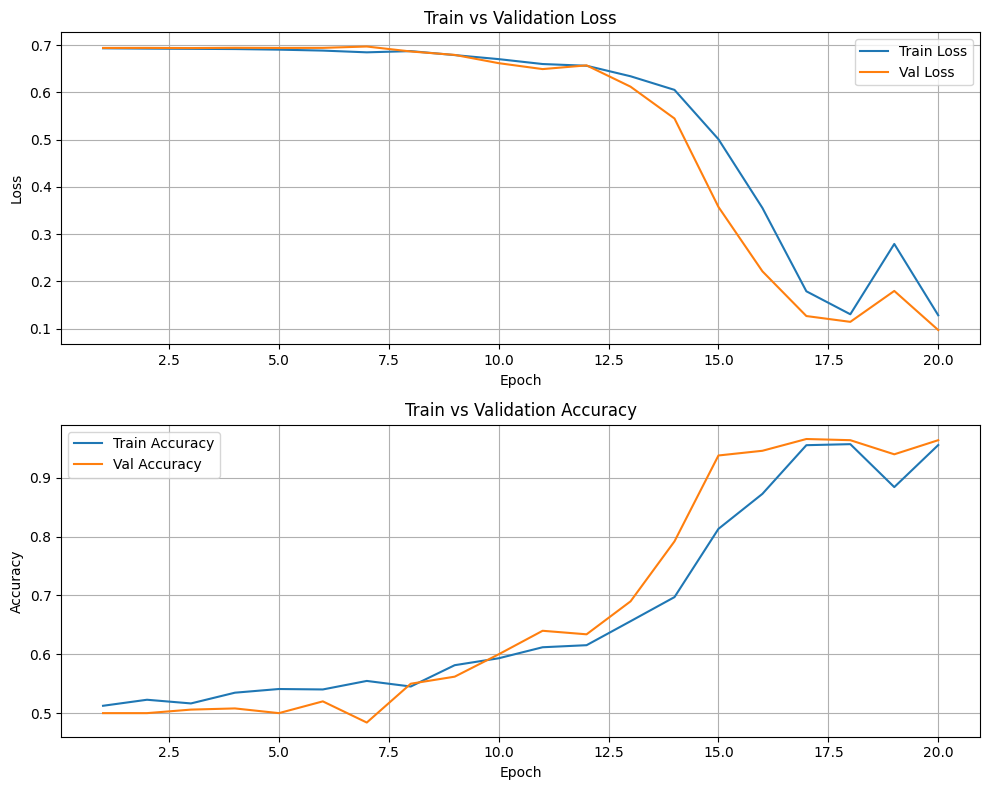

In [152]:
import matplotlib.pyplot as plt
import os

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 8))

# 1) Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

# 2) Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

filename = os.path.basename(DATA_PATH)

print(filename)
plt.savefig(f"images/{filename}.png")

plt.show()